In [1]:
!pip install grad-cam
!pip install 'accelerate>=0.26.0'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 13.4 MB/s eta 0:00:0000:0100:01
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=7d79e97db9547462d721e2ce0176c56de8288a47bc700b3c5bd85089392b0b90
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f43a9e89608af648de401b96415bebbd1f
Successfully built grad-cam


In [2]:
import pandas as pd
import numpy as np
import os
import branched_resnet_v2 as br
from transformers import Trainer, TrainingArguments, set_seed
import datetime
from safetensors.torch import load_file

import torch

print(torch.__version__)

# Set device and verify CUDA availability
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

2.5.1+cu121
CUDA available: True
CUDA version: 12.1
Device count: 1
Current device: 0
Device name: NVIDIA RTX A2000 Laptop GPU
Using device: cuda


In [3]:
D21_MODELS = [
    "/data/models/D21_CV_models/parabolic_increasing_lambda_scheduler_fold_0_final_model_2025-09-26_01-45-15/model.safetensors",
]

In [4]:
# load test datasets

test_ds1 = br.dataset_load('/data/test/D21_processed_undistorted_test_data.npz')
# test_ds3 = br.dataset_load('/data/test/D21_processed_ring_artifact_test_data.npz')
# test_ds4 = br.dataset_load('/data/test/D21_processed_rotate_90_test_data.npz')
# test_ds6 = br.dataset_load('/data/test/D21_processed_uniform_noise_test_data.npz')

test_names = [
    'undistorted',
    # 'ring_artifact', 
    # 'rotate', 
    # 'uniform',
]

In [5]:
metrics_df = pd.DataFrame(columns=['eval_loss', 'eval_accuracy_branch1', 'eval_accuracy_branch2', 'eval_f1_branch1', 'eval_f1_branch2', 'eval_precision_branch1', 'eval_precision_branch2', 'eval_recall_branch1', 'eval_recall_branch2'])

def build_row(results, dataset_name):
    row = {'Dataset': dataset_name,
           'eval_loss': None,
           'eval_accuracy_branch1': None,
           'eval_accuracy_branch2': None,
           'eval_f1_branch1': None,
           'eval_f1_branch2': None,
           'eval_precision_branch1': None,
           'eval_precision_branch2': None,
           'eval_recall_branch1': None,
           'eval_recall_branch2': None}
    row.update(results)
    return row

def parabolic_increasing_lambda_scheduler(epoch, total_epochs, start_value=0.0, end_value=1.0):
    progress = epoch / total_epochs
    return start_value + (end_value - start_value) * (progress ** 2)

lambda_scheduler = parabolic_increasing_lambda_scheduler
NUM_EPOCHS = 50
fold = 1
for model_path in D21_MODELS:
    print(f"Evaluating D21 model from fold {fold}: {model_path}")
    fold += 1

    # Load safetensors weights
    state_dict = load_file(model_path)

    # Rebuild model and load weights
    config = br.ResNetConfig()
    model = br.ResNetForMultiLabel(config, num_d1_classes=11, num_d2_classes=2)
    model.load_state_dict(state_dict)
    model.eval()

    # TrainingArguments (we only care about eval here)
    training_args = TrainingArguments(
        output_dir=f"./results/fold_{fold}",
        per_device_eval_batch_size=32,
        dataloader_drop_last=False,
        report_to="none",   # don’t log to W&B unless you want to
    )

    # Wrap with Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer=None,  # if you need preprocessing, pass tokenizer
        compute_metrics=br.make_metrics_fn(model),
        callbacks=[br.LambdaUpdateCallback(model, lambda_scheduler, NUM_EPOCHS)]
    )

    # Evaluate on each test dataset
    for i, dataset in enumerate([test_ds1]):
        print(f"Evaluating on test dataset {i+1}")
        results = trainer.evaluate(eval_dataset=dataset)
        # Store results in your DataFrame
        row = build_row(results, f'Fold_{fold}_{test_names[i]}')
        metrics_df = pd.concat([metrics_df, pd.DataFrame([row])], ignore_index=True)



Evaluating D21 model from fold 1: /data/models/D21_CV_models/parabolic_increasing_lambda_scheduler_fold_0_final_model_2025-09-26_01-45-15/model.safetensors


/tmp/ipykernel_17/2721381103.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluating on test dataset 1


/tmp/ipykernel_17/2721381103.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([row])], ignore_index=True)


In [7]:
# Save metrics to CSV
metrics_df.to_csv("/data/tmp.csv", index=False)

In [9]:
display(metrics_df)
# The metrics are a little weird... but it at least does make sense that the branch 1 accuracy is high.

,eval_loss,eval_accuracy_branch1,eval_accuracy_branch2,eval_f1_branch1,eval_f1_branch2,eval_precision_branch1,eval_precision_branch2,eval_recall_branch1,eval_recall_branch2,Dataset,eval_model_preparation_time,eval_lambda,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.917102,0.946451,0.001069,0.940819,0.001068,0.943217,0.5,0.940258,0.000534,Fold_2_undistorted,0.0031,0.25,361.4917,49.18,1.538


In [178]:
# Use the above model for GradCAM analysis.

In [179]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import torch
import matplotlib.pyplot as plt

In [180]:
organs = [
    "bladder",
    "femur-left",
    "femur-right",
    "heart",
    "kidney-left",
    "kidney-right",
    "liver",
    "lung-left",
    "lung-right",
    "pancreas",
    "spleen",
]

domains = [
    "source",
    "target",
]

In [197]:
class ResNetForMultiLabelForGradCAM(torch.nn.Module):
    """Wrapper for our DANN for compatibility with pytorch_grad_cam library."""
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.eval_labels_1 = None
        self.eval_labels_2 = None

    def choose_branch(self, branch):
        assert branch in {1, 2}
        self.eval_branch = branch

    def set_targets(self, labels1=None, labels2=None):
        """These don't affect the actual predicted logits for branches 1 or 2 - 
        we just have loss in our model class's forward definition
        so something needs to be provided here to avoid a crash."""
        self.eval_labels_1 = labels1
        self.eval_labels_2 = labels2

    def forward(self, x):
        output = self.model(pixel_values=x, labels1=self.eval_labels_1, labels2=self.eval_labels_2)
        if self.eval_branch ==1:
            return output.branch1_logits
        elif self.eval_branch ==2:
            return output.branch2_logits
        else:
            raise Exception("Which branch?")

# # picking a part of the resnet
# for name, module in model_for_grad_cam.model.resnet.named_children():
#     print(name, type(module))

# for i, module in enumerate(model_for_grad_cam.model.resnet.encoder.stages):
#     print(f"stage {i}")
#     for name, module in module.named_children():
#         print(name, module)


In [198]:
def show_tensor_image_with_cam(tensor, cam=None):
    assert len(tensor.shape) == 4, "Expecting [N, C, H, W]"

    # Remove batch dimension
    img = tensor.squeeze(0)

    # Move to range [0, 1]
    img = (img + 1.) / 2.

    # Transpose [C, H, W] to [H, W, C]
    img_np = img.numpy().transpose(1, 2, 0)

    if cam is not None:
        cam_np = cam.squeeze(0)
        cam_np = np.clip(cam_np, 0, 1)

        # RGB heatmap
        heatmap = plt.cm.jet(cam_np)[..., :3]
        overlay = (0.4 * heatmap + 0.6 * img_np)

        plt.imshow(np.clip(overlay, 0, 1))
    else:
        plt.imshow(img_np.clip(0, 1))

    plt.axis('off')
    plt.show()



ResNetConvLayer(
  (convolution): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (normalization): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)


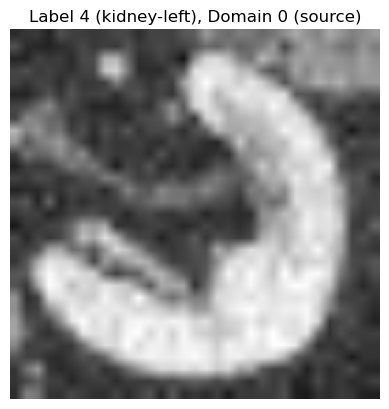

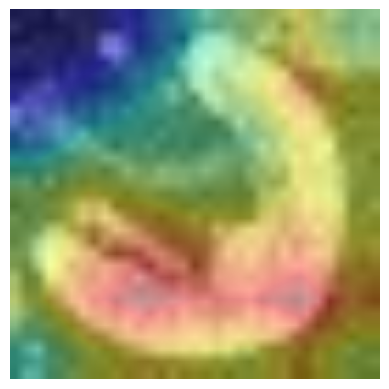

In [207]:
for case_number, target_layer in [
    (
        10,
        # This is the last 3x3 convolutional layer - so it should provide the most abstract spatial features
        model_for_grad_cam.model.resnet.encoder.stages[-1].layers[-1].layer[1]
    ),
]:
    
    print(target_layer)
    
    example_case = test_ds1[case_number]
    example_image = example_case['pixel_values'].unsqueeze(0)
    example_image_gpu = example_image.clone().detach().to('cuda')
    example_label = example_case['labels1']
    example_label_gpu = torch.tensor([example_label]).to('cuda')
    example_domain = example_case['labels2']
    example_domain_gpu = torch.tensor([example_domain]).to('cuda')

    model_for_grad_cam = ResNetForMultiLabelForGradCAM(model)
    model_for_grad_cam.model.eval()
    model_for_grad_cam.choose_branch(1)
    model_for_grad_cam.set_targets(example_label_gpu, example_domain_gpu)
    model_for_grad_cam(example_image_gpu)
    
    cam = GradCAM(model=model_for_grad_cam, target_layers=[target_layer])
    example_cam = cam(input_tensor=example_image, targets=[ClassifierOutputTarget(example_label)])
    
    plt.title(f"Label {example_label} ({organs[example_label]}), Domain {example_domain} ({domains[example_domain]})")
    show_tensor_image_with_cam(example_image)
    show_tensor_image_with_cam(example_image, example_cam)

In [ ]:
# Integrated Gradients - should be a tensorflow implementation or pytorch one. This one is 

In [212]:
!pip install captum Flask-Compress

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 403.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 768.2 kB/s eta 0:00:0000:0100:02
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.2
    Uninstalling numpy-2.1.2:
      Successfully uninstalled numpy-2.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
